In [1]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from shapely.geometry import Point, Polygon

Download data from [https://www.getthedata.com/downloads/open_pubs.csv.zip](https://www.getthedata.com/downloads/open_pubs.csv.zip)

In [2]:
columns = OrderedDict()
columns['fsa_id'] = np.int32
columns['name'] = object
columns['address'] = object
columns['postcode'] = object
columns['easting'] = np.int64
columns['northing'] = np.int64
columns['latitude'] = np.float64
columns['longitude'] = np.float64
columns['local_authority'] = object

utm_coordinates = ['easting','northing']

# The data has NA values as "\N"
data = pd.read_csv('open_pubs.csv', header=None,
                   names=columns.keys(), na_values='\\N',dtype=columns)

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51167 entries, 0 to 51166
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   fsa_id           51167 non-null  int32  
 1   name             51167 non-null  object 
 2   address          51167 non-null  object 
 3   postcode         51167 non-null  object 
 4   easting          51167 non-null  int64  
 5   northing         51167 non-null  int64  
 6   latitude         51021 non-null  float64
 7   longitude        51021 non-null  float64
 8   local_authority  51167 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(4)
memory usage: 3.3+ MB


fsa_id       easting      northing      latitude     longitude
count   51167.000000   51167.00000  5.116700e+04  51021.000000  51021.000000
mean   274125.877968  426471.13026  2.984699e+05     52.724477     -1.634084
std    155144.138238   97863.88972  3.538166e+05      1.510243      1.432743
min        24.000000   78109.00000 -5.527598e+06     49.892485     -7.384525
25%    152225.000000  358112.00000  1.806795e+05     51.512586     -2.623855
50%    278080.000000  427351.00000  2.893100e+05     52.497179     -1.587807
75%    401760.500000  506452.50000  4.108115e+05     53.593666     -0.448415
max    546122.000000  655277.00000  1.209661e+06     60.764969      1.757763

From [geopandas docs](https://geopandas.org/docs/user_guide/projections.html):
>For reference, a few very common projections and their EPSG codes:
>* WGS84 Latitude/Longitude: "EPSG:4326"
>* UTM Zones (North): "EPSG:32633"
>* UTM Zones (South): "EPSG:32733"

Shape files obtained from [geofabrik.de](http://download.geofabrik.de/europe/great-britain/england/greater-london.html).

In [18]:
# Dropping rows with missing values
data.dropna(inplace=True)

# Generating GeoDataFrame using WGS84
crs = 'EPSG:32633'
geometry = [Point(xy) for xy in zip(data['longitude'], data['latitude'])]
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

map_layers = {
    'pois': {
        'gdf': gpd.read_file('gis_osm_pois_a_free_1.shp'),
        'color': 'lightgreen',
        'zorder': 0
    },
    'water': {
        'gdf': gpd.read_file('gis_osm_water_a_free_1.shp'),
        'color': 'lightskyblue',
        'zorder': 1
    },
    'buildings': {
        'gdf': gpd.read_file('gis_osm_buildings_a_free_1.shp'),
        'color': 'khaki',
        'zorder': 2
    },
    'roads': {
        'gdf': gpd.read_file('gis_osm_roads_free_1.shp'),
        'color': 'gray',
        'zorder': 3
    }
}

In [16]:
def plot_silhouette(X_train):
    '''Use K-means clustering for the first 6 cluster sizes and show the silhouette plots'''
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,17))

    for n_clusters, ax in zip(range(2, 8), axes.flatten()):
        km = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=0)
        sv = SilhouetteVisualizer(km, ax=ax).fit(X_train)
        ax.set_title(f'{n_clusters} clusters score = {sv.silhouette_score_:.2f}', fontsize=20)


def plot_clusters(gdf):
    '''Plot the clusters on a map '''
    fig, ax = plt.subplots(figsize=(20,20))

    # Plotting map layers and pub markers
    for layer in map_layers.values():
        layer['gdf'].plot(ax=ax, color=layer['color'], alpha=0.4, zorder=layer['zorder'])
    gdf.plot(column='cluster', ax=ax, markersize=40,
                     categorical=True, marker='o', cmap='tab10', zorder=4)

    # axis config
    ax.set_aspect('equal')
    longitude, latitude = gdf['longitude'], gdf['latitude']
    margin = 0.001
    ax.set_xlim(longitude.min() - margin, longitude.max() + margin)
    ax.set_ylim(latitude.min() - margin, latitude.max() + margin)
    ax.set_xticks([])
    ax.set_yticks([]);

# Westminster

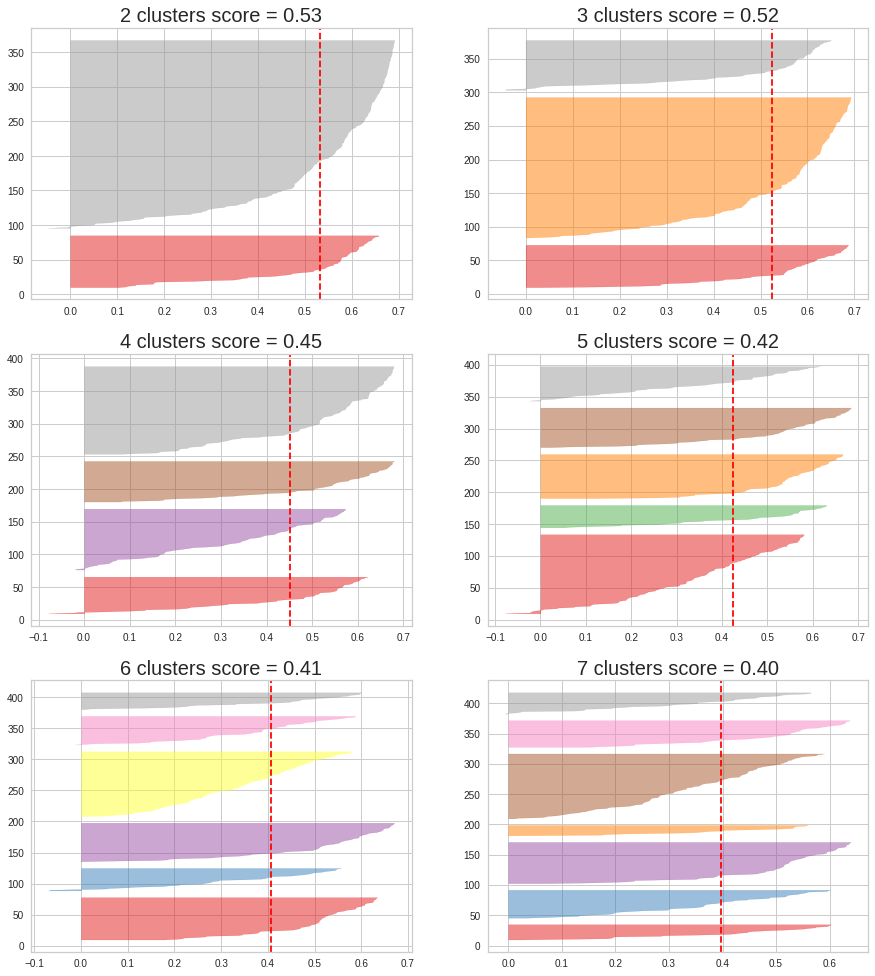

In [5]:
westminster = gdf.loc[gdf['local_authority'] == 'Westminster'].copy()
plot_silhouette(westminster[utm_coordinates])

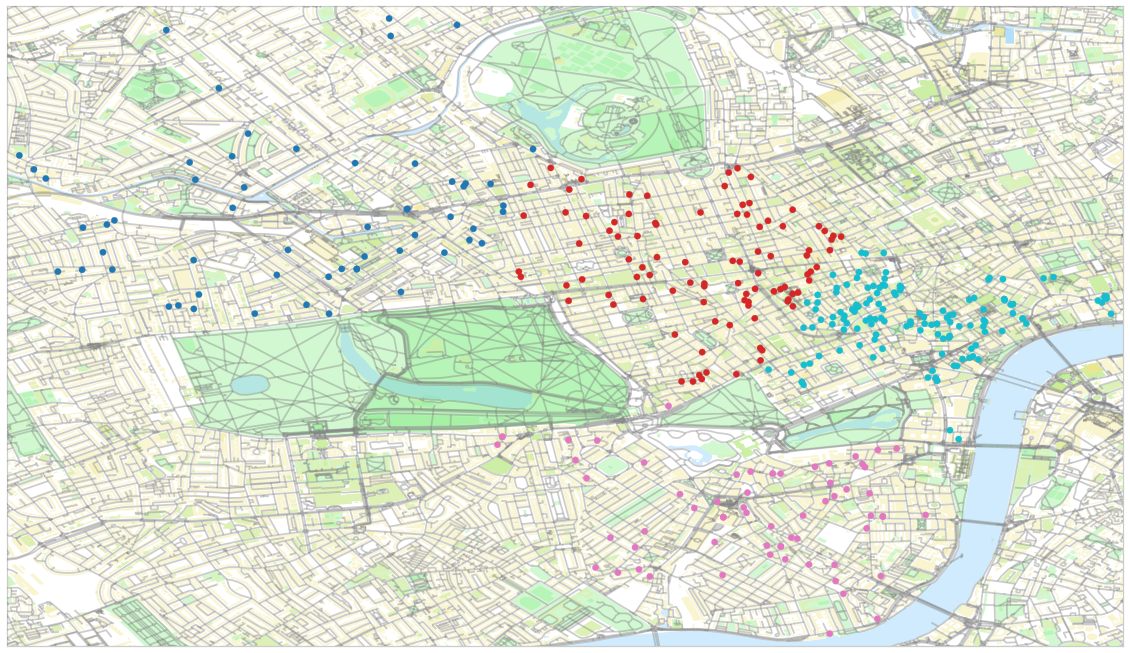

In [19]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=0)
westminster['cluster'] = km.fit_predict(westminster[utm_coordinates])
plot_clusters(westminster)

# City of London

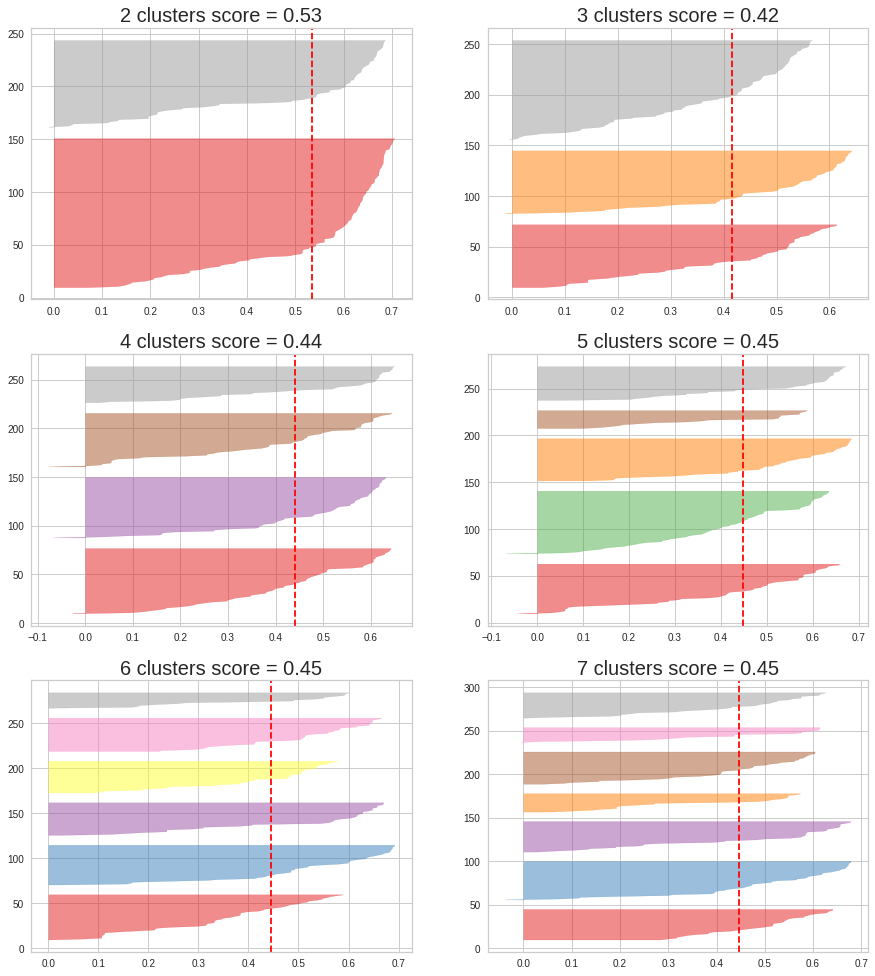

In [22]:
city_of_london = gdf.loc[gdf['local_authority'] == 'City of London'].copy()
plot_silhouette(city_of_london[utm_coordinates])

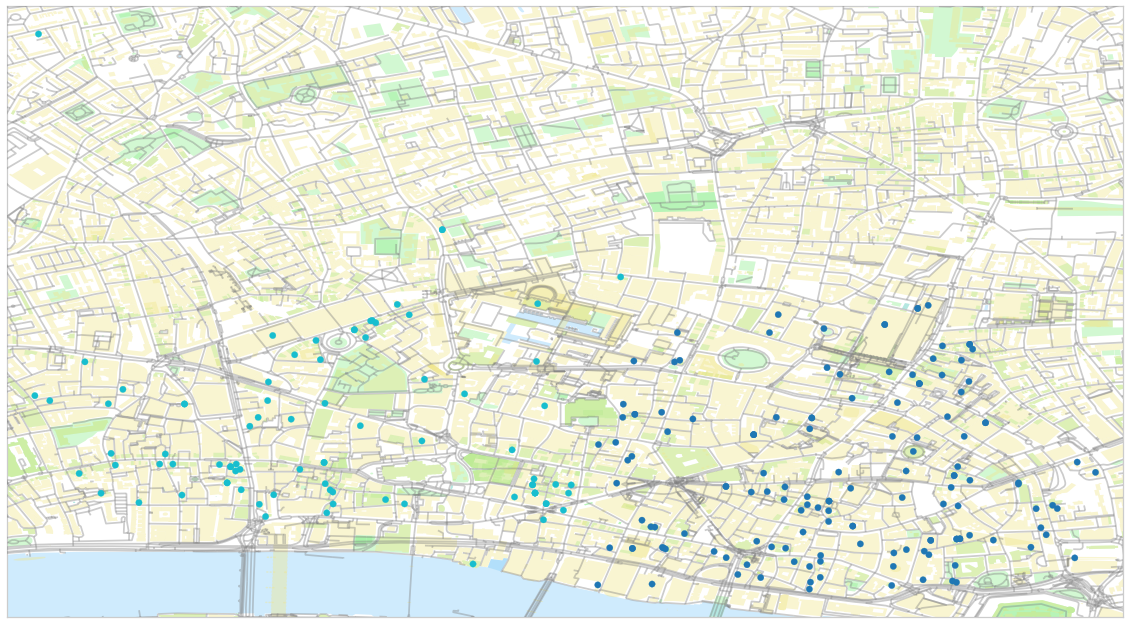

In [26]:
n_clusters = 2
km = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=0)
city_of_london['cluster'] = km.fit_predict(city_of_london[utm_coordinates])
plot_clusters(city_of_london)

# Camden

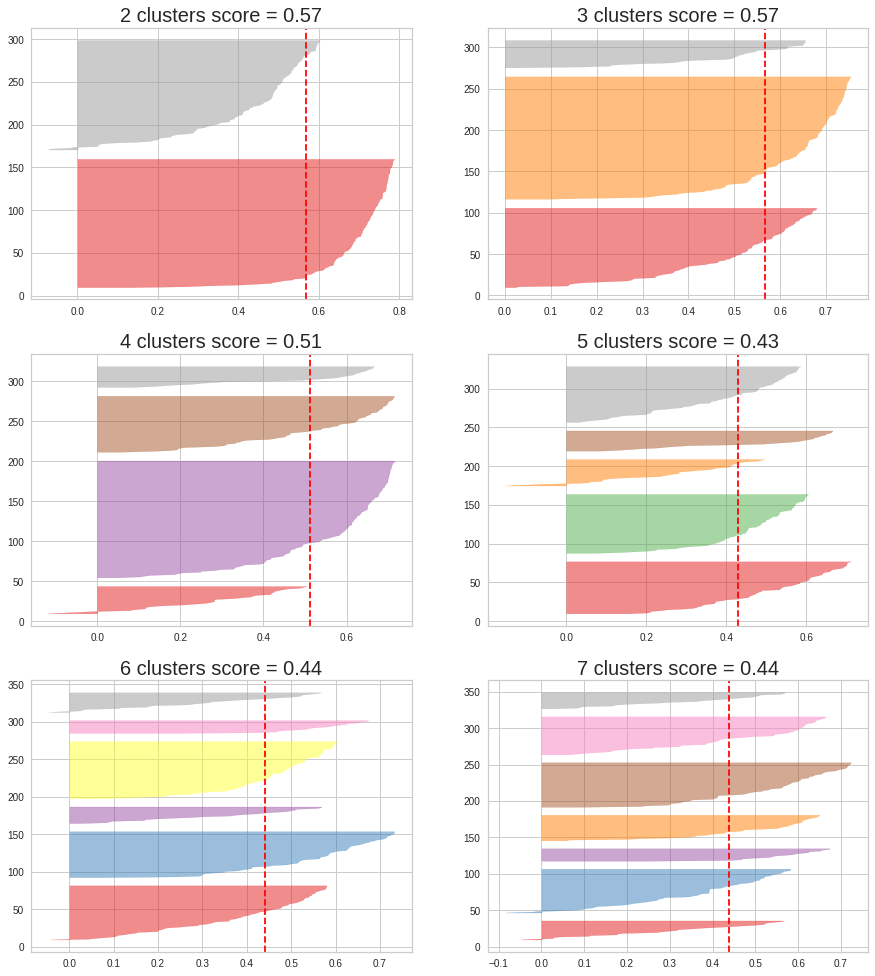

In [24]:
camden = gdf.loc[gdf['local_authority'] == 'Camden'].copy()
plot_silhouette(camden[utm_coordinates])

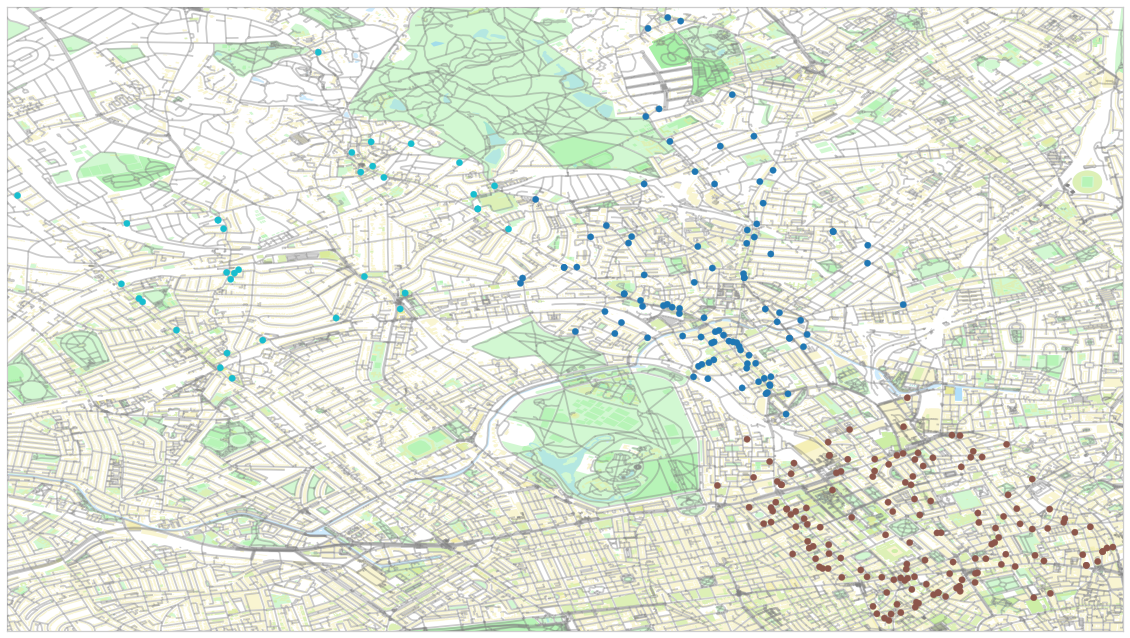

In [25]:
n_clusters = 3
km = KMeans(n_clusters=n_clusters, max_iter=1000, random_state=0)
camden['cluster'] = km.fit_predict(camden[utm_coordinates])
plot_clusters(camden)